In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk

In [22]:
TICKER = 'SPY'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

SHIFT = 5
RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30

# what subsetion of that data are you interested in
LOOKBACK = 100

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

# define the target variable (also called dependent variable, or y)
def add_target(df, shift=SHIFT):

    # what is the close price SHIFT days from now?
    df[f'Close + {shift}'] = df['Close'].shift(-shift)

    # what is the change in close price SHIFT days from now?
    df['Target'] = df[f'Close + {shift}'] - df['Close']

    return df

def add_RSI(df, length=RSI_LENGTH):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color='red')
    plt.axhline(OVERSOLD, color='green')

    return df.dropna()

def generate_regression_output(df, features='RSI', target='Target'):

    # FIX 2: Use the 'features' and 'target' variables, not 'x' and 'y'
    subset = df[[features, target]].dropna()

    # reshape for sklearn
    X = subset[[features]].values # 2d
    y = subset[target].values # 1d

    model = sk.linear_model.LinearRegression()
    model.fit(X, y)

    # use the regression model to "predict" the target variable
    y_pred = model.predict(X)

    # what is the relationship between features and target?
    r2 = sk.metrics.r2_score(y, y_pred)
    #how thoroughly are the x and y variables related to each other

    # coef, intercept, r2... mse later on
    print(f"Coefficient: {model.coef_[0]}")
    print(f"Intercept: {model.intercept_}")
    print(f"R2: {r2}")
    
    plt.figure()
    plt.scatter(X,y)
    
    # FIX 1: Use plt.xlabel() and plt.ylabel() to set axis labels
    plt.xlabel(f"{features}")
    plt.ylabel(f"{target}")

    return df

def main():
    df = get_data()
    df = add_target(df)
    df = add_RSI(df)
    df = generate_regression_output(df)
    return df


/var/folders/yl/gn9fldpj69169vhn466y4klh0000gn/T/ipykernel_25209/985003808.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval=interval, period=PERIOD)
[*********************100%***********************]  1 of 1 completed

Coefficient: -0.3015778073095761
Intercept: 23.912908157442633
R2: 0.15323206920176724


Price,Close,High,Low,Open,Volume,Close + 5,Target,RSI
8224,668.450012,669.369995,663.059998,663.169983,72545400,673.109985,4.659973,68.527029
8225,669.219971,670.570007,666.780029,670.450012,56896000,671.159973,1.940002,69.660078
8226,669.210022,672.679993,668.159973,669.989990,70494400,653.020020,-16.190002,66.241332
8227,671.609985,672.510010,669.460022,671.619995,54623300,663.039978,-8.570007,70.561234
8228,669.119995,672.989990,667.669983,672.539978,72020100,662.229980,-6.890015,67.125257
8229,673.109985,673.210022,669.419983,670.250000,60702200,665.169983,-7.940002,67.981617
8230,671.159973,673.940002,669.210022,673.530029,66501900,660.640015,-10.519958,60.989944
8231,653.020020,673.950012,652.840027,672.130005,159422600,664.390015,11.369995,35.880628
8232,663.039978,665.130005,659.770020,660.650024,79560500,671.299988,8.260010,49.846336
8233,662.229980,665.830017,653.169983,657.169983,88779600,670.989990,8.760010,51.045724


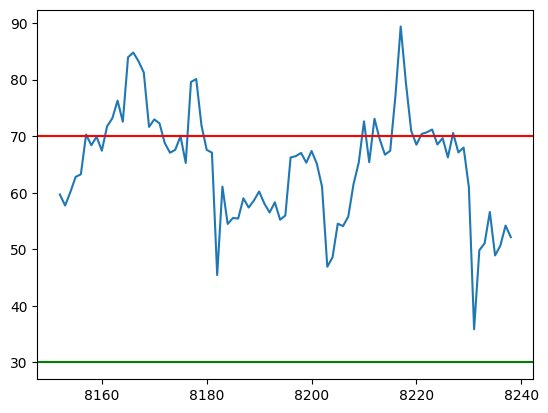

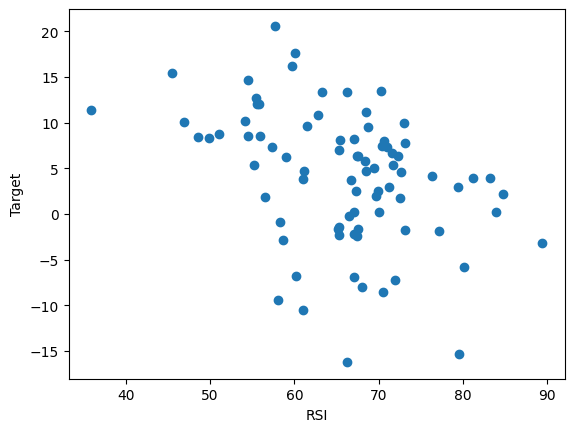

In [23]:

df = main()
df
df.tail(10)